In [183]:
## 1. Cargar Bibliotecas y Datos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tabulate import tabulate
# Cargar el conjunto de datos
train = pd.read_csv('D:\\Ale\\Competitions\\Spaceship_Titanic_Port\\Data\\train.csv')
test = pd.read_csv('D:\\Ale\\Competitions\\Spaceship_Titanic_Port\\Data\\test.csv')

In [184]:
def porcentaje_nulos(df):
    nulos = df.isnull().sum()
    porcentaje = (nulos / len(df)) * 100
    return pd.DataFrame({'Column': df.columns, 'Porcentaje Nulos': porcentaje}).sort_values(by='Porcentaje Nulos', ascending=False)

# Calcular y mostrar el porcentaje de nulos en train
porcentaje_train = porcentaje_nulos(train)
print("Porcentaje de Nulos en el Conjunto de Entrenamiento:")
print(tabulate(porcentaje_train, headers='keys', tablefmt='pretty', showindex=False))

# Calcular y mostrar el porcentaje de nulos en test
porcentaje_test = porcentaje_nulos(test)
print("\nPorcentaje de Nulos en el Conjunto de Prueba:")
print(tabulate(porcentaje_test, headers='keys', tablefmt='pretty', showindex=False))

Porcentaje de Nulos en el Conjunto de Entrenamiento:
+--------------+--------------------+
|    Column    |  Porcentaje Nulos  |
+--------------+--------------------+
|  CryoSleep   | 2.4962613597147127 |
| ShoppingMall | 2.392729782583688  |
|     VIP      | 2.3352122397331185 |
|  HomePlanet  | 2.312205222592891  |
|     Name     | 2.300701714022777  |
|    Cabin     | 2.289198205452663  |
|    VRDeck    | 2.1626596111814105 |
|  FoodCourt   | 2.105142068330841  |
|     Spa      | 2.105142068330841  |
| Destination  | 2.093638559760727  |
| RoomService  | 2.082135051190613  |
|     Age      | 2.0591280340503855 |
| PassengerId  |        0.0         |
| Transported  |        0.0         |
+--------------+--------------------+

Porcentaje de Nulos en el Conjunto de Prueba:
+--------------+--------------------+
|    Column    |  Porcentaje Nulos  |
+--------------+--------------------+
|  FoodCourt   | 2.4783726911386488 |
|     Spa      | 2.3614683189151275 |
|    Cabin     | 2.3380874

In [185]:
# Rellenar valores nulos en el conjunto de entrenamiento
for column in train.columns:
    if train[column].dtype == 'object':
        train[column].fillna(train[column].mode()[0], inplace=True)
    else:
        train[column].fillna(train[column].mean(), inplace=True)

# Rellenar valores nulos en el conjunto de entrenamiento
for column in test.columns:
    if test[column].dtype == 'object':
        test[column].fillna(test[column].mode()[0], inplace=True)
    else:
        test[column].fillna(test[column].mean(), inplace=True)

C:\Users\Gubier\AppData\Local\Temp\ipykernel_3116\4056328096.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[column].fillna(train[column].mode()[0], inplace=True)
C:\Users\Gubier\AppData\Local\Temp\ipykernel_3116\4056328096.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[column].fillna(train

In [186]:
# Manejo de valores nulos en la columna 'Cabin'
train['Cabin'].fillna('Unknown', inplace=True)

# Extracción de características de 'Cabin' basado en la estructura conocida
train[['Deck', 'NumCabin', 'Side']] = train['Cabin'].str.split('/', expand=True)

# Mostrar el DataFrame procesado
print(train[['Cabin', 'Deck', 'NumCabin', 'Side']].head())

# Manejo de valores nulos en la columna 'Cabin'
test['Cabin'].fillna('Unknown', inplace=True)

# Extracción de características de 'Cabin' basado en la estructura conocida
test[['Deck', 'NumCabin', 'Side']] = test['Cabin'].str.split('/', expand=True)

# Mostrar el DataFrame procesado
print(test[['Cabin', 'Deck', 'NumCabin', 'Side']].head())

   Cabin Deck NumCabin Side
0  B/0/P    B        0    P
1  F/0/S    F        0    S
2  A/0/S    A        0    S
3  A/0/S    A        0    S
4  F/1/S    F        1    S
   Cabin Deck NumCabin Side
0  G/3/S    G        3    S
1  F/4/S    F        4    S
2  C/0/S    C        0    S
3  C/1/S    C        1    S
4  F/5/S    F        5    S


In [187]:
# 1. Crear la columna TotalSpend para train y test
for df in [train, test]:  # Iterar sobre ambos DataFrames
    df['TotalSpend'] = (
        df['RoomService'].fillna(0) + 
        df['FoodCourt'].fillna(0) + 
        df['ShoppingMall'].fillna(0) + 
        df['Spa'].fillna(0) + 
        df['VRDeck'].fillna(0)
    )

# 2. Crear la columna AgeGroup para train y test
def categorize_age(age):
    if age < 18:
        return 'Joven'
    elif 18 <= age < 60:
        return 'Adulto'
    else:
        return 'Anciano'

for df in [train, test]:  # Iterar sobre ambos DataFrames
    df['AgeGroup'] = df['Age'].apply(categorize_age)

# 3. Crear la columna SpentMoney para train y test
for df in [train, test]:  # Iterar sobre ambos DataFrames
    df['SpentMoney'] = (df['TotalSpend'] > 0).astype(int)  # 1 si ha gastado, 0 si no

# Mostrar el DataFrame de train con las nuevas características
print(train[['TotalSpend', 'AgeGroup', 'SpentMoney']].head())

# Mostrar el DataFrame de test con las nuevas características
print(test[['TotalSpend', 'AgeGroup', 'SpentMoney']].head())

   TotalSpend AgeGroup  SpentMoney
0         0.0   Adulto           0
1       736.0   Adulto           1
2     10383.0   Adulto           1
3      5176.0   Adulto           1
4      1091.0    Joven           1
   TotalSpend AgeGroup  SpentMoney
0         0.0   Adulto           0
1      2832.0   Adulto           1
2         0.0   Adulto           0
3      7418.0   Adulto           1
4       645.0   Adulto           1


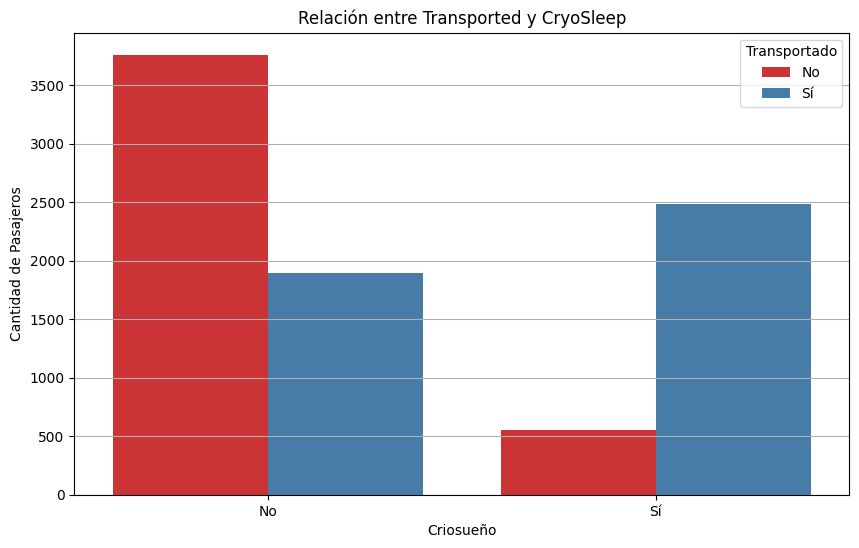

In [188]:
# Graficar la relación entre 'Transported' y 'CryoSleep'
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='CryoSleep', hue='Transported', palette='Set1')

# Personalización del gráfico
plt.title('Relación entre Transported y CryoSleep')
plt.xlabel('Criosueño')
plt.ylabel('Cantidad de Pasajeros')
plt.legend(title='Transportado', labels=['No', 'Sí'])
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.grid(axis='y')

# Mostrar el gráfico
plt.show()

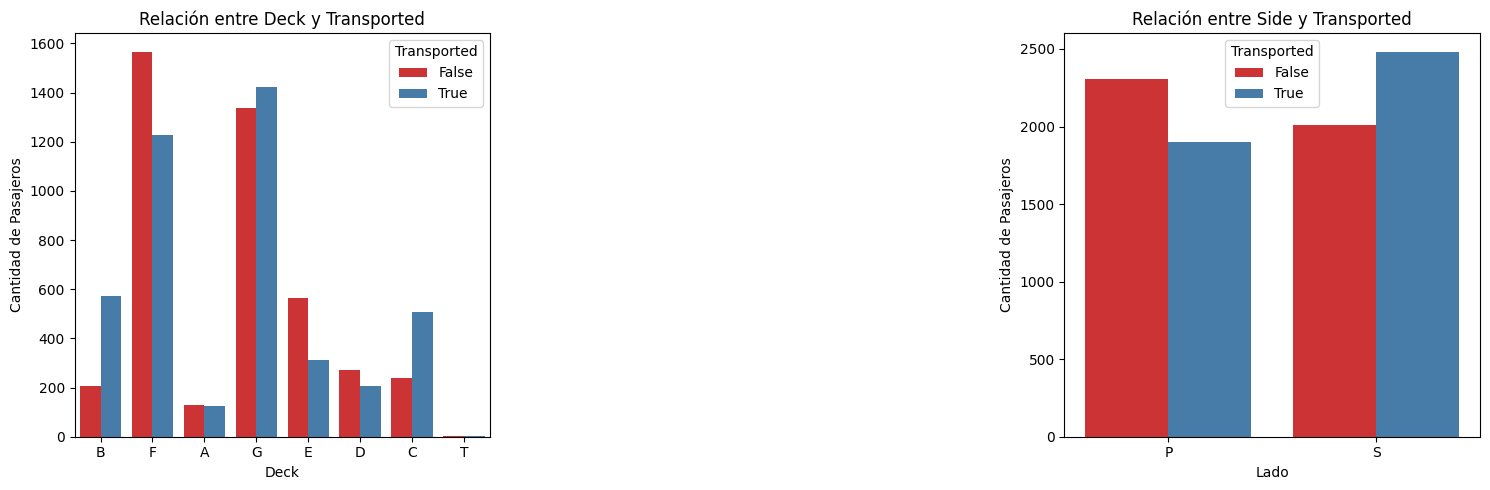

In [189]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=train, x='Deck', hue='Transported', palette='Set1')
plt.title('Relación entre Deck y Transported')
plt.xlabel('Deck')
plt.ylabel('Cantidad de Pasajeros')
plt.legend(title='Transported')

# Graficar la relación entre 'Side' y 'Embarked'
plt.subplot(1, 3, 3)
sns.countplot(data=train, x='Side', hue='Transported', palette='Set1')
plt.title('Relación entre Side y Transported')
plt.xlabel('Lado')
plt.ylabel('Cantidad de Pasajeros')
plt.legend(title='Transported')

# Ajustar el diseño
plt.tight_layout()
plt.show()

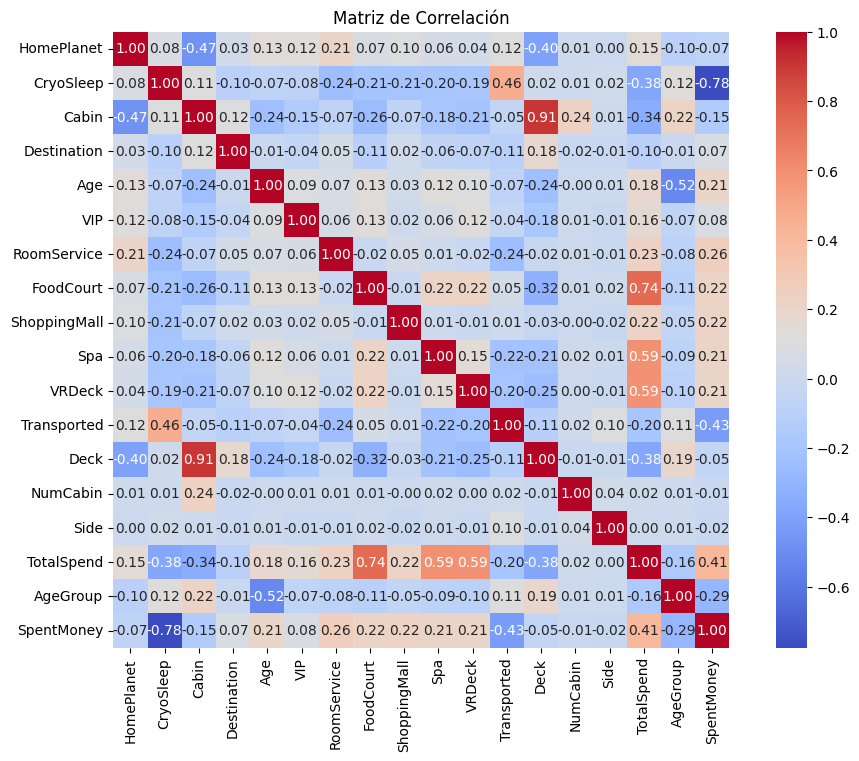

In [190]:
# Crear una copia del DataFrame para evitar cambios en el original
train_encoded = train.copy()

# Eliminar las columnas 'Name' y 'PassengerId'
train_encoded.drop(columns=['Name', 'PassengerId'], inplace=True)

# Definir las columnas a codificar, filtrando las de tipo object y bool
columns_to_encode = train_encoded.select_dtypes(include=['object', 'bool']).columns.tolist()

# Aplicar Label Encoding a cada columna categórica
label_encoders = {}
for column in columns_to_encode:
    le = LabelEncoder()
    train_encoded[column] = le.fit_transform(train_encoded[column].astype(str))  # Convertir a string para asegurar compatibilidad
    label_encoders[column] = le  # Guardar el encoder para posibles usos futuros

# Generar la matriz de correlación
correlation_matrix = train_encoded.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlación')
plt.show()

Accuracy en el conjunto de validación: 0.8033352501437608


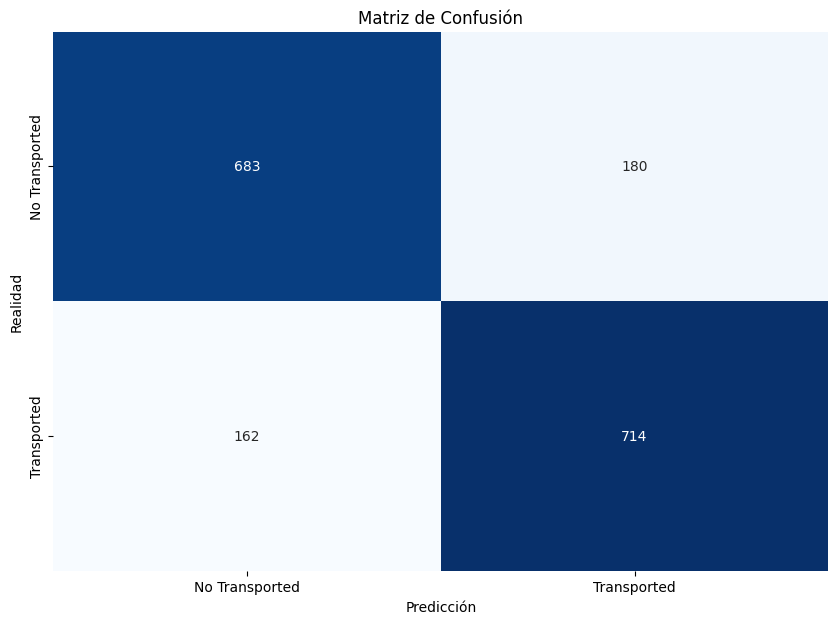

Archivo de presentación creado: submission_catboost.csv


In [191]:
# 2. Preparar los datos
X = train.drop(['Transported', 'Name', 'PassengerId', 'Cabin'], axis=1)  # Excluye las columnas que no usarás
y = train['Transported']

# 3. Codificar las columnas categóricas usando pd.get_dummies
X = pd.get_dummies(X, drop_first=True)

# Repetir el proceso para el conjunto de prueba
X_test_final = test.drop(['Name', 'PassengerId', 'Cabin'], axis=1)
X_test_final = pd.get_dummies(X_test_final, drop_first=True)

# Asegurarse de que X_test_final tenga las mismas características que X
X_test_final = X_test_final.reindex(columns=X.columns, fill_value=0)

# 4. Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# 5. Entrenar el modelo CatBoost
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0)
catboost_model.fit(X_train, y_train)

# 6. Hacer predicciones en el conjunto de validación
y_val_pred = catboost_model.predict(X_val)

# 7. Evaluar el modelo
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy en el conjunto de validación:", accuracy)

# 8. Matriz de confusión
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Transported', 'Transported'], 
            yticklabels=['No Transported', 'Transported'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# 9. Hacer predicciones en el conjunto de prueba
final_predictions = catboost_model.predict(X_test_final)

# Convertir las predicciones de 0/1 a True/False
final_predictions_bool = final_predictions.astype(bool)

# 10. Crear el DataFrame para la presentación
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Transported': final_predictions_bool
})

# 11. Guardar el DataFrame en un archivo CSV
submission.to_csv('submission_catboost.csv', index=False)

print("Archivo de presentación creado: submission_catboost.csv")